<a href="https://colab.research.google.com/github/jdmartinezrs/chatbotDevelopmentPython/blob/main/chatConprecioYDosKilometrajes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install git+https://github.com/gunthercox/ChatterBot.git@master
!pip install chatterbot_corpus

  Cloning https://github.com/gunthercox/ChatterBot.git (to revision master) to /tmp/pip-req-build-62g8zad7
  Running command git clone --filter=blob:none --quiet https://github.com/gunthercox/ChatterBot.git /tmp/pip-req-build-62g8zad7
  Resolved https://github.com/gunthercox/ChatterBot.git to commit 1b26cd4a24848b8f1caf06b9046dfc2dee3caf98
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ChatterBot: filename=chatterbot-1.2.7-py3-none-any.whl size=76246 sha256=11bd5038aeb8f11100b289eb153c40a7d788699cdfdaa73c9eb8ebcc9641bb4e
  Stored in directory: /tmp/pip-ephem-wheel-cache-nvgaaa63/wheels/fd/03/55/c2af3bb3db528c97656fd03d65adc6492c0d41496bfafd3485
Successfully built ChatterBot
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.5/240.5 kB 4.6 MB/s eta 0:00:00


In [2]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.3/323.3 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.9 MB/s eta 0:00:00


In [15]:
import gradio as gr
from chatterbot import ChatBot
from chatterbot.trainers import ListTrainer

vehiculos = {
    "irrigador": {"base": 6000, "coeficiente": 0.13, "umbrales": (0, 10000, 16000), "tarifa": 10},
    "volqueta sencilla": {"base": 7000, "coeficiente": 0.16, "umbrales": (0, 8000, 14000), "tarifa": 12},
    "dobletroque": {"base": 6000, "coeficiente": 0.20, "umbrales": (0, 7000, 12000), "tarifa": 13},
    "grua": {"base": 5500, "coeficiente": 0.23, "umbrales": (0, 6000, 10000), "tarifa": 14},
    "carro tanque": {"base": 6500, "coeficiente": 0.25, "umbrales": (0, 9000, 15000), "tarifa": 15},
}
TASA_CAMBIO_DOLAR = 4000

bot = ChatBot("MantenimientoBot")
trainer = ListTrainer(bot)
trainer.train([
    "Hola", "Hola, ¿qué vehículo deseas revisar?",
    "Buenos días", "Hola, ¿qué vehículo deseas revisar?",
    "Buenas tardes", "Hola, ¿qué vehículo deseas revisar?",
    "me gustaria revisar mi vehiculo", "¿qué vehículo tienes?",
    "me gustaria revisar otro vehiculo", "¿qué deseas revisar?",
    "otro", "¿qué vehículo deseas revisar?",
    "¿Qué sabes hacer?", "Puedo decirte cuándo darle mantenimiento a tu vehículo.",
    "¿Para qué sirves?", "Puedo decirte cuándo darle mantenimiento a tu vehículo.",
    "okey", "Hola, ¿qué vehículo deseas revisar?",
    "Chao", "¡Hasta luego! 🚚",
    "Adiós", "¡Hasta luego! 🚚",
    "cuanto cuesta la revisión?", "Puedo decirte el costo estimado si ya ingresaste los datos.",
    "¿Cuál es el valor en dólares?", "Puedo convertirlo si ya calculaste el mantenimiento.",
    "¿Cuánto vale?", "Puedo mostrarte el costo en pesos y dólares.",
])

# Variables globales
ultimo_precio = None
ultimo_precio_usd = None
tipo_vehiculo_actual = None
datos_vehiculo = None
esperando_km_actual = False
esperando_km_base = False
km_actual_temp = None


def clasificar_mantenimiento_por_km(tipo, km_desde_ultimo, datos):
    _, umbral_cercano_km, umbral_urgente_km = datos["umbrales"]
    if km_desde_ultimo >= umbral_urgente_km:
        excedido = km_desde_ultimo - umbral_urgente_km
        return f"❌ {tipo.upper()} necesita mantenimiento urgente. Has pasado {excedido} km del límite."
    elif km_desde_ultimo >= umbral_cercano_km:
        return f"⚠️ {tipo.upper()} pronto requiere mantenimiento."
    else:
        return f"✅ {tipo.upper()} operando normalmente."


def calcular_precio_mantenimiento(desgaste, tarifa):
    return desgaste * tarifa


def responder(usuario_input):
    global ultimo_precio, ultimo_precio_usd, tipo_vehiculo_actual, datos_vehiculo
    global esperando_km_actual, esperando_km_base, km_actual_temp

    entrada = usuario_input.strip().lower()
    tipos = list(vehiculos.keys())

    if entrada in ["salir", "chao", "adiós"]:
        return "¡Hasta luego! 🚚"

    if entrada in ["cuanto cuesta la revisión?", "cuanto vale?", "precio", "costo"]:
        if ultimo_precio is not None:
            return f"El costo estimado del mantenimiento es {ultimo_precio:,.2f} COP."
        else:
            return "Aún no has calculado un mantenimiento. Por favor indica el vehículo."

    if entrada in ["¿cuál es el valor en dólares?", "valor en dolares", "precio en usd"]:
        if ultimo_precio_usd is not None:
            return f"El equivalente en dólares es ${ultimo_precio_usd:.2f} USD."
        else:
            return "Aún no has calculado el mantenimiento. Inicia con un vehículo."

    if esperando_km_actual:
        try:
            km_actual_temp = int(entrada)
            if km_actual_temp < 0 or km_actual_temp > 25000:
                return "Por favor ingresa un valor entre 0 y 25000 km."
            esperando_km_actual = False
            esperando_km_base = True
            return "¿En qué kilometraje se hizo el último mantenimiento?"
        except:
            return "Por favor ingresa un número válido para el kilometraje actual."

    if esperando_km_base:
        try:
            km_base = int(entrada)
            if km_base < 0 or km_base > km_actual_temp:
                return "El valor debe ser menor o igual al kilometraje actual."
            km_desde_ultimo = km_actual_temp - km_base
            coef = datos_vehiculo["coeficiente"]
            tarifa = datos_vehiculo["tarifa"]
            desgaste = km_desde_ultimo * coef
            precio_cop = calcular_precio_mantenimiento(desgaste, tarifa)
            precio_usd = round(precio_cop / TASA_CAMBIO_DOLAR, 2)
            ultimo_precio = precio_cop
            ultimo_precio_usd = precio_usd
            esperando_km_base = False

            resultado = f"""
Has recorrido {km_desde_ultimo} km desde el último mantenimiento.
El desgaste estimado es {desgaste:.2f} unidades.
{clasificar_mantenimiento_por_km(tipo_vehiculo_actual, km_desde_ultimo, datos_vehiculo)}
Puedes cotizar el precio de la revisión, el precio del mantenimiento es aparte"
            """
            return resultado.strip()
        except:
            return "Por favor ingresa un número válido para el último mantenimiento."

    match = [tipo for tipo in tipos if tipo in entrada]
    if match:
        tipo_vehiculo_actual = match[0]
        datos_vehiculo = vehiculos[tipo_vehiculo_actual]
        esperando_km_actual = True
        return f"¿Cuántos km ha recorrido el {tipo_vehiculo_actual.upper()}?"

    respuesta = bot.get_response(entrada)
    return str(respuesta)


with gr.Blocks() as iface:
    gr.Markdown("## 🚗 MantenimientoBot\nAsistente.")

    # Mostrar la respuesta en la parte superior
    respuesta = gr.Textbox(label="Respuesta", interactive=False)

    # Campo de entrada y botón de envío en la parte inferior
    with gr.Row():
        mensaje = gr.Textbox(label="Escribe tu mensaje", lines=1, scale=4)
        enviar_btn = gr.Button("Enviar", scale=1)

    def responder_y_limpiar(texto):
        return responder(texto), ""

    # Lógica de envío
    mensaje.submit(responder_y_limpiar, inputs=mensaje, outputs=[respuesta, mensaje])
    enviar_btn.click(responder_y_limpiar, inputs=mensaje, outputs=[respuesta, mensaje])

iface.launch()


List Trainer: 28it [00:00, 1378.22it/s]


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://04c51b01506d043651.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


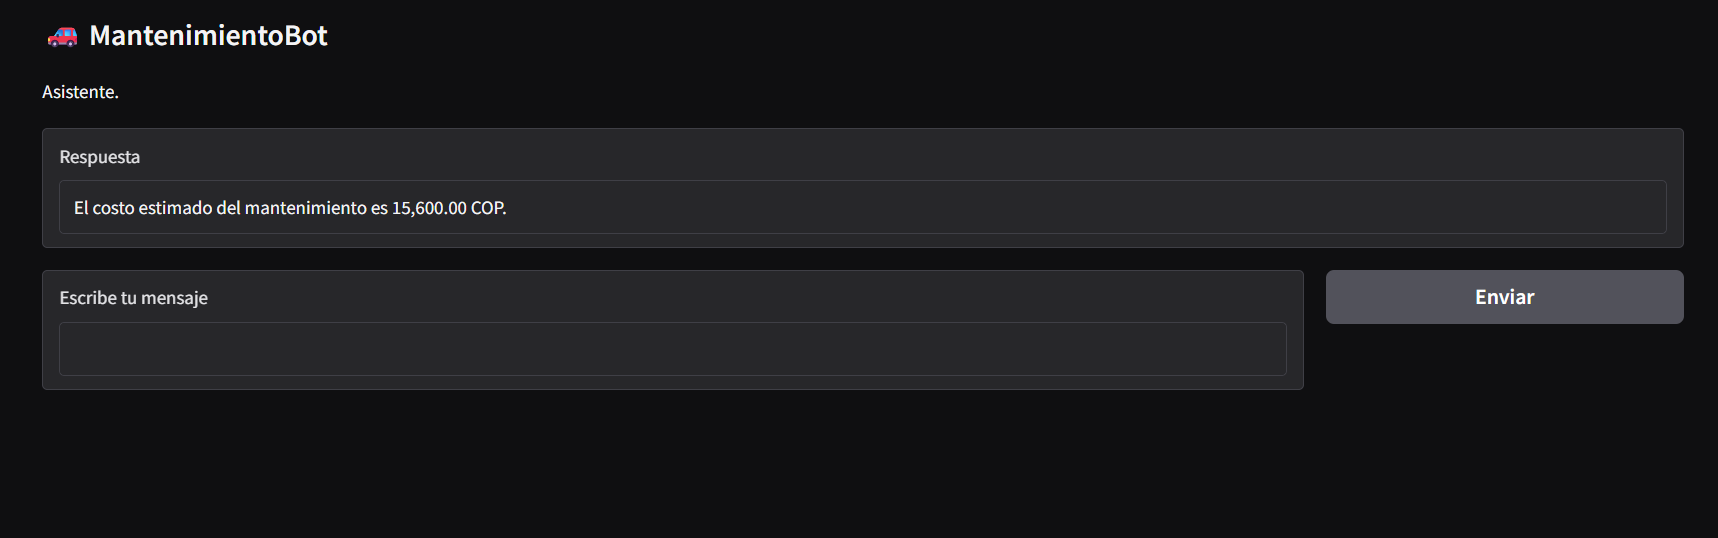